<a href="https://colab.research.google.com/github/elmasperron97/FINE/blob/main/Centros_de_distribucin_Modelo_avanzado.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

🚀 Optimizador Avanzado de Centros de Distribución
🚀 INICIANDO ANÁLISIS COMPLETO DE OPTIMIZACIÓN
📥 Descargando datos desde GitHub...
✅ Datos cargados: 88 clientes
   • Quito: 35 clientes
   • Guayaquil: 42 clientes
   • Cuenca: 11 clientes
   • Demanda total: 13,639 unidades/mes

🇪🇨 ESCENARIO 1: Un Centro Nacional
----------------------------------------
📍 Ubicación óptima: (-1.4204, -79.1892)
💰 Costo total mensual: $4,787,033
📊 Distancia promedio: 138.0 km
⚠️  Distancia máxima: 170.1 km

🏙️ ESCENARIO 2: Un Centro por Ciudad
----------------------------------------
📍 3 centros ubicados
   Centro 1: Centro Quito (-0.2123, -78.5171)
   Centro 2: Centro Guayaquil (-2.1618, -79.9206)
   Centro 3: Centro Cuenca (-2.8809, -78.9951)
💰 Costo total mensual: $504,694
📊 Distancia promedio: 11.0 km
⚠️  Distancia máxima: 20.2 km

📊 ANÁLISIS DE TRADE-OFF: Determinando Número Óptimo

🔄 Evaluando 1 centro(s)...
   ✅ Mejor método: P-Median
   💰 Costo total: $4,783,984
   📍 Distancia promedio: 137.8 km



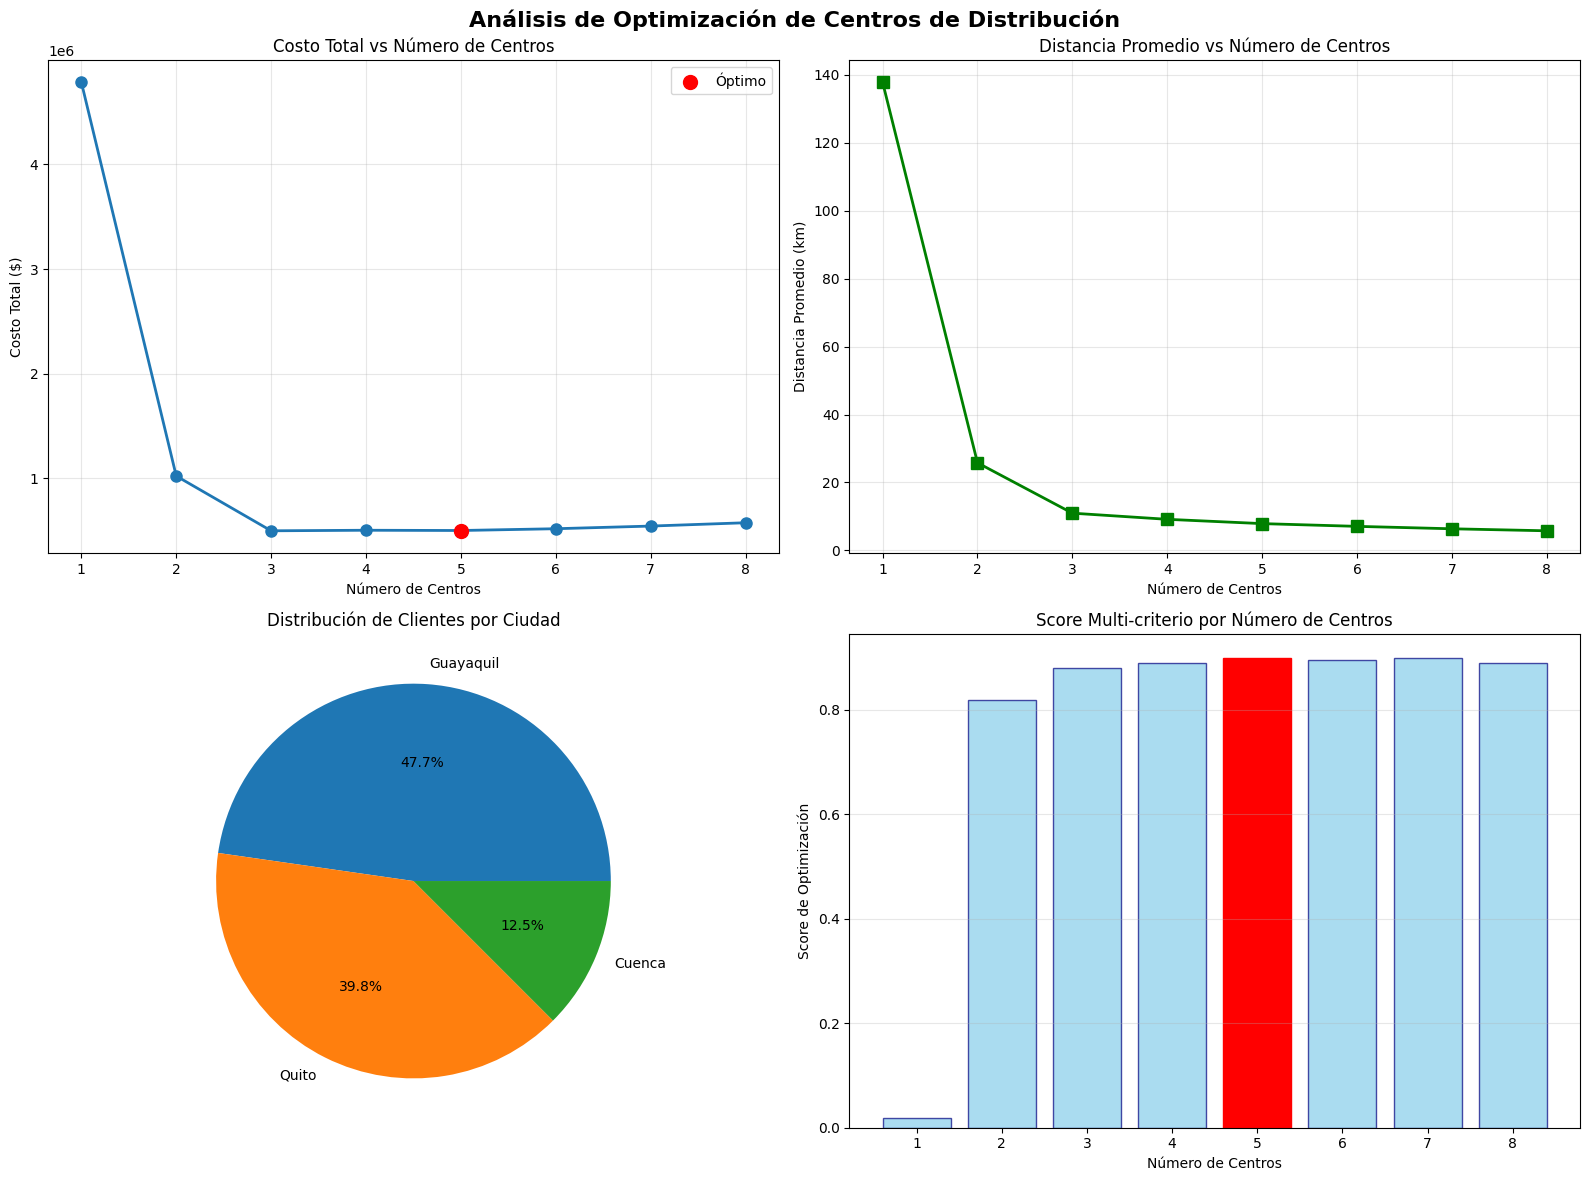


🎉 ANÁLISIS COMPLETADO
✅ Solución óptima encontrada: 5 centros
💰 Costo mensual optimizado: $517,434

📋 COORDENADAS DE CENTROS ÓPTIMOS PARA IMPLEMENTACIÓN:
Centro 1: Latitud -2.127663, Longitud -79.998327
          Google Maps: https://maps.google.com/?q=-2.1276625102995315,-79.99832679564568
Centro 2: Latitud -0.224902, Longitud -78.532799
          Google Maps: https://maps.google.com/?q=-0.22490165749596389,-78.53279859794513
Centro 3: Latitud -2.867336, Longitud -79.001945
          Google Maps: https://maps.google.com/?q=-2.8673360576318556,-79.0019449823718
Centro 4: Latitud -2.269442, Longitud -79.886350
          Google Maps: https://maps.google.com/?q=-2.2694417233082307,-79.8863498179712
Centro 5: Latitud -2.096459, Longitud -79.855164
          Google Maps: https://maps.google.com/?q=-2.09645866936307,-79.8551643127578


In [2]:
import requests
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.optimize import minimize
from sklearn.cluster import KMeans
import random
import math
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

class OptimizadorCentrosAvanzado:
    """
    Optimizador avanzado que determina automáticamente el número óptimo
    de centros de distribución evaluando múltiples escenarios
    """

    def __init__(self, url_datos):
        """
        Inicializa con URL del archivo de datos de GitHub
        """
        self.url_datos = url_datos
        self.df_clientes = None
        self.resultados_analisis = {}

        # Configuración de costos (ajustables según tu negocio)
        self.costos_config = {
            'costo_fijo_centro': 50000,      # Costo mensual de operar un centro
            'costo_por_km': 2.5,             # Costo por km por unidad transportada
            'capacidad_max_centro': 10000,   # Capacidad máxima por centro
            'factor_tiempo_servicio': 1.2    # Factor de penalización por distancia
        }

        print("🚀 Optimizador Avanzado de Centros de Distribución")
        print("=" * 60)

    def cargar_datos(self):
        """
        Descarga y carga los datos desde GitHub
        """
        print("📥 Descargando datos desde GitHub...")

        try:
            response = requests.get(self.url_datos)
            response.raise_for_status()

            # Parsear el contenido del archivo
            lineas = response.text.strip().split('\n')

            # Saltar la primera línea (encabezado)
            datos = []
            for linea in lineas[1:]:
                partes = linea.strip().split()
                if len(partes) >= 5:
                    datos.append({
                        'cliente_id': int(partes[0]),
                        'ciudad': partes[1],
                        'latitud': float(partes[2]),
                        'longitud': float(partes[3]),
                        'demanda_mensual': float(partes[4])
                    })

            self.df_clientes = pd.DataFrame(datos)

            print(f"✅ Datos cargados: {len(self.df_clientes)} clientes")
            print(f"   • Quito: {len(self.df_clientes[self.df_clientes['ciudad'] == 'Quito'])} clientes")
            print(f"   • Guayaquil: {len(self.df_clientes[self.df_clientes['ciudad'] == 'Guayaquil'])} clientes")
            print(f"   • Cuenca: {len(self.df_clientes[self.df_clientes['ciudad'] == 'Cuenca'])} clientes")
            print(f"   • Demanda total: {self.df_clientes['demanda_mensual'].sum():,.0f} unidades/mes")

            return True

        except Exception as e:
            print(f"❌ Error al cargar datos: {e}")
            return False

    def calcular_distancia_haversine(self, lat1, lon1, lat2, lon2):
        """
        Calcula distancia geodésica entre dos puntos en km
        """
        R = 6371  # Radio de la Tierra en km

        lat1, lon1, lat2, lon2 = map(math.radians, [lat1, lon1, lat2, lon2])
        dlat = lat2 - lat1
        dlon = lon2 - lon1

        a = math.sin(dlat/2)**2 + math.cos(lat1) * math.cos(lat2) * math.sin(dlon/2)**2
        c = 2 * math.asin(math.sqrt(a))

        return R * c

    def calcular_costo_total_escenario(self, centros, incluir_costos_fijos=True):
        """
        Calcula el costo total para un escenario dado
        """
        costo_transporte = 0
        costo_fijo = 0
        distancias = []
        asignaciones = []

        # Calcular costos de transporte
        for _, cliente in self.df_clientes.iterrows():
            min_distancia = float('inf')
            centro_asignado = 0

            for i, centro in enumerate(centros):
                dist = self.calcular_distancia_haversine(
                    cliente['latitud'], cliente['longitud'],
                    centro['lat'], centro['lon']
                )
                if dist < min_distancia:
                    min_distancia = dist
                    centro_asignado = i

            costo_cliente = cliente['demanda_mensual'] * min_distancia * self.costos_config['costo_por_km']
            costo_transporte += costo_cliente
            distancias.append(min_distancia)

            asignaciones.append({
                'cliente_id': cliente['cliente_id'],
                'centro_asignado': centro_asignado,
                'distancia': min_distancia,
                'costo_transporte': costo_cliente
            })

        # Calcular costos fijos
        if incluir_costos_fijos:
            costo_fijo = len(centros) * self.costos_config['costo_fijo_centro']

        return {
            'costo_transporte': costo_transporte,
            'costo_fijo': costo_fijo,
            'costo_total': costo_transporte + costo_fijo,
            'distancia_promedio': np.mean(distancias),
            'distancia_maxima': np.max(distancias),
            'num_centros': len(centros),
            'asignaciones': asignaciones
        }

    # ESCENARIO 1: UN CENTRO NACIONAL
    def escenario_centro_nacional(self):
        """
        Evalúa tener un solo centro para todo el país
        """
        print("\n🇪🇨 ESCENARIO 1: Un Centro Nacional")
        print("-" * 40)

        # Encontrar centro geográfico ponderado por demanda
        total_demanda = self.df_clientes['demanda_mensual'].sum()
        lat_centro = (self.df_clientes['latitud'] * self.df_clientes['demanda_mensual']).sum() / total_demanda
        lon_centro = (self.df_clientes['longitud'] * self.df_clientes['demanda_mensual']).sum() / total_demanda

        centros = [{'lat': lat_centro, 'lon': lon_centro, 'nombre': 'Centro Nacional'}]
        resultado = self.calcular_costo_total_escenario(centros)

        print(f"📍 Ubicación óptima: ({lat_centro:.4f}, {lon_centro:.4f})")
        print(f"💰 Costo total mensual: ${resultado['costo_total']:,.0f}")
        print(f"📊 Distancia promedio: {resultado['distancia_promedio']:.1f} km")
        print(f"⚠️  Distancia máxima: {resultado['distancia_maxima']:.1f} km")

        self.resultados_analisis['centro_nacional'] = resultado
        return resultado

    # ESCENARIO 2: UN CENTRO POR CIUDAD
    def escenario_centro_por_ciudad(self):
        """
        Evalúa tener un centro en cada ciudad principal
        """
        print("\n🏙️ ESCENARIO 2: Un Centro por Ciudad")
        print("-" * 40)

        centros = []
        for ciudad in ['Quito', 'Guayaquil', 'Cuenca']:
            clientes_ciudad = self.df_clientes[self.df_clientes['ciudad'] == ciudad]

            if len(clientes_ciudad) > 0:
                # Centro ponderado por demanda en cada ciudad
                total_demanda = clientes_ciudad['demanda_mensual'].sum()
                lat_centro = (clientes_ciudad['latitud'] * clientes_ciudad['demanda_mensual']).sum() / total_demanda
                lon_centro = (clientes_ciudad['longitud'] * clientes_ciudad['demanda_mensual']).sum() / total_demanda

                centros.append({
                    'lat': lat_centro,
                    'lon': lon_centro,
                    'nombre': f'Centro {ciudad}'
                })

        resultado = self.calcular_costo_total_escenario(centros)

        print(f"📍 {len(centros)} centros ubicados")
        for i, centro in enumerate(centros):
            print(f"   Centro {i+1}: {centro['nombre']} ({centro['lat']:.4f}, {centro['lon']:.4f})")

        print(f"💰 Costo total mensual: ${resultado['costo_total']:,.0f}")
        print(f"📊 Distancia promedio: {resultado['distancia_promedio']:.1f} km")
        print(f"⚠️  Distancia máxima: {resultado['distancia_maxima']:.1f} km")

        self.resultados_analisis['centro_por_ciudad'] = resultado
        return resultado

    # ALGORITMO P-MEDIAN PARA MÚLTIPLES OPCIONES
    def algoritmo_p_median(self, p):
        """
        Implementa algoritmo P-Median para p centros
        """
        # Usar K-Means ponderado por demanda como aproximación rápida
        coords_ponderadas = []
        for _, cliente in self.df_clientes.iterrows():
            peso = max(1, int(cliente['demanda_mensual'] / 50))  # Ponderar por demanda
            for _ in range(peso):
                coords_ponderadas.append([cliente['latitud'], cliente['longitud']])

        if len(coords_ponderadas) > 0:
            kmeans = KMeans(n_clusters=p, random_state=42, n_init=10)
            kmeans.fit(coords_ponderadas)

            centros = []
            for i, centro in enumerate(kmeans.cluster_centers_):
                centros.append({
                    'lat': centro[0],
                    'lon': centro[1],
                    'nombre': f'Centro P-Median {i+1}'
                })

            return centros
        else:
            return []

    # ALGORITMO GENÉTICO AVANZADO
    def algoritmo_genetico_avanzado(self, num_centros, poblacion=30, generaciones=100):
        """
        Implementa algoritmo genético adaptativo para optimización global
        """
        print(f"🧬 Ejecutando Algoritmo Genético ({num_centros} centros)...")

        # Límites geográficos
        lat_min, lat_max = self.df_clientes['latitud'].min(), self.df_clientes['latitud'].max()
        lon_min, lon_max = self.df_clientes['longitud'].min(), self.df_clientes['longitud'].max()

        def evaluar_fitness(individuo):
            centros = []
            for i in range(0, len(individuo), 2):
                centros.append({'lat': individuo[i], 'lon': individuo[i+1]})
            resultado = self.calcular_costo_total_escenario(centros, incluir_costos_fijos=False)
            return resultado['costo_transporte']

        # Población inicial mejorada
        poblacion_actual = []

        # 30% de la población: centros en ciudades principales
        ciudades_centros = self.df_clientes.groupby('ciudad')[['latitud', 'longitud']].mean()
        for _ in range(int(poblacion * 0.3)):
            individuo = []
            ciudades_elegidas = random.sample(list(ciudades_centros.index), min(num_centros, len(ciudades_centros)))
            for ciudad in ciudades_elegidas:
                individuo.extend([ciudades_centros.loc[ciudad, 'latitud'], ciudades_centros.loc[ciudad, 'longitud']])
            # Completar con posiciones aleatorias si es necesario
            while len(individuo) < num_centros * 2:
                individuo.extend([random.uniform(lat_min, lat_max), random.uniform(lon_min, lon_max)])
            poblacion_actual.append(individuo)

        # 70% restante: posiciones completamente aleatorias
        for _ in range(poblacion - len(poblacion_actual)):
            individuo = []
            for _ in range(num_centros):
                individuo.extend([random.uniform(lat_min, lat_max), random.uniform(lon_min, lon_max)])
            poblacion_actual.append(individuo)

        mejor_solucion = None
        mejor_fitness = float('inf')
        historial_fitness = []

        for gen in range(generaciones):
            # Evaluar fitness
            fitness_scores = []
            for individuo in poblacion_actual:
                fitness = evaluar_fitness(individuo)
                fitness_scores.append(fitness)

                if fitness < mejor_fitness:
                    mejor_fitness = fitness
                    mejor_solucion = individuo.copy()

            historial_fitness.append(mejor_fitness)

            if gen % 20 == 0:
                print(f"   Generación {gen}: Mejor fitness = ${mejor_fitness:,.0f}")

            # Selección por torneo
            nueva_poblacion = []

            # Elitismo: mantener los mejores 20%
            indices_ordenados = np.argsort(fitness_scores)
            elite_size = int(poblacion * 0.2)
            for i in range(elite_size):
                nueva_poblacion.append(poblacion_actual[indices_ordenados[i]])

            # Generar resto por cruzamiento y mutación
            while len(nueva_poblacion) < poblacion:
                # Selección por torneo
                padre1 = self._seleccion_torneo(poblacion_actual, fitness_scores)
                padre2 = self._seleccion_torneo(poblacion_actual, fitness_scores)

                # Cruzamiento
                hijo = self._cruzamiento(padre1, padre2)

                # Mutación adaptativa (menor probabilidad conforme converge)
                prob_mutacion = 0.1 * (1 - gen / generaciones)
                hijo = self._mutacion(hijo, prob_mutacion, lat_min, lat_max, lon_min, lon_max)

                nueva_poblacion.append(hijo)

            poblacion_actual = nueva_poblacion

        # Convertir mejor solución a formato de centros
        centros_optimos = []
        for i in range(0, len(mejor_solucion), 2):
            centros_optimos.append({
                'lat': mejor_solucion[i],
                'lon': mejor_solucion[i+1],
                'nombre': f'Centro AG {i//2 + 1}'
            })

        return centros_optimos, mejor_fitness, historial_fitness

    def _seleccion_torneo(self, poblacion, fitness_scores, tam_torneo=3):
        """Selección por torneo"""
        participantes = random.sample(range(len(poblacion)), tam_torneo)
        ganador = min(participantes, key=lambda i: fitness_scores[i])
        return poblacion[ganador].copy()

    def _cruzamiento(self, padre1, padre2):
        """Cruzamiento uniforme"""
        hijo = []
        for i in range(len(padre1)):
            if random.random() < 0.5:
                hijo.append(padre1[i])
            else:
                hijo.append(padre2[i])
        return hijo

    def _mutacion(self, individuo, prob_mutacion, lat_min, lat_max, lon_min, lon_max):
        """Mutación gaussiana adaptativa"""
        for i in range(len(individuo)):
            if random.random() < prob_mutacion:
                if i % 2 == 0:  # Latitud
                    individuo[i] += random.gauss(0, 0.01)
                    individuo[i] = max(lat_min, min(lat_max, individuo[i]))
                else:  # Longitud
                    individuo[i] += random.gauss(0, 0.01)
                    individuo[i] = max(lon_min, min(lon_max, individuo[i]))
        return individuo

    # ANÁLISIS COMPLETO DE TRADE-OFF
    def analisis_tradeoff_completo(self):
        """
        Análisis exhaustivo para determinar número óptimo de centros
        """
        print("\n📊 ANÁLISIS DE TRADE-OFF: Determinando Número Óptimo")
        print("=" * 60)

        resultados_tradeoff = []

        # Evaluar de 1 a 8 centros
        for num_centros in range(1, 9):
            print(f"\n🔄 Evaluando {num_centros} centro(s)...")

            # Método 1: P-Median (K-Means ponderado)
            centros_pmedian = self.algoritmo_p_median(num_centros)
            resultado_pmedian = self.calcular_costo_total_escenario(centros_pmedian)

            # Método 2: Algoritmo Genético (solo para 2-6 centros para eficiencia)
            if 2 <= num_centros <= 6:
                centros_ag, fitness_ag, _ = self.algoritmo_genetico_avanzado(num_centros, poblacion=20, generaciones=50)
                resultado_ag = self.calcular_costo_total_escenario(centros_ag)
            else:
                resultado_ag = resultado_pmedian

            # Tomar el mejor resultado
            if resultado_ag['costo_total'] < resultado_pmedian['costo_total']:
                mejor_resultado = resultado_ag
                mejor_metodo = 'Algoritmo Genético'
            else:
                mejor_resultado = resultado_pmedian
                mejor_metodo = 'P-Median'

            # Calcular métricas adicionales
            eficiencia_costo = mejor_resultado['costo_transporte'] / mejor_resultado['num_centros']
            cobertura_servicio = 100 - (mejor_resultado['distancia_promedio'] / mejor_resultado['distancia_maxima']) * 100

            resultado_completo = {
                'num_centros': num_centros,
                'costo_total': mejor_resultado['costo_total'],
                'costo_transporte': mejor_resultado['costo_transporte'],
                'costo_fijo': mejor_resultado['costo_fijo'],
                'distancia_promedio': mejor_resultado['distancia_promedio'],
                'distancia_maxima': mejor_resultado['distancia_maxima'],
                'eficiencia_costo': eficiencia_costo,
                'cobertura_servicio': cobertura_servicio,
                'mejor_metodo': mejor_metodo
            }

            resultados_tradeoff.append(resultado_completo)

            print(f"   ✅ Mejor método: {mejor_metodo}")
            print(f"   💰 Costo total: ${mejor_resultado['costo_total']:,.0f}")
            print(f"   📍 Distancia promedio: {mejor_resultado['distancia_promedio']:.1f} km")

        # Análisis de resultados
        df_tradeoff = pd.DataFrame(resultados_tradeoff)

        # Encontrar número óptimo usando múltiples criterios
        # Normalizar métricas para comparación
        df_tradeoff['costo_norm'] = df_tradeoff['costo_total'] / df_tradeoff['costo_total'].max()
        df_tradeoff['distancia_norm'] = df_tradeoff['distancia_promedio'] / df_tradeoff['distancia_promedio'].max()
        df_tradeoff['eficiencia_norm'] = 1 - (df_tradeoff['eficiencia_costo'] / df_tradeoff['eficiencia_costo'].max())

        # Función de utilidad multi-criterio
        df_tradeoff['score_optimizacion'] = (
            0.4 * (1 - df_tradeoff['costo_norm']) +          # 40% peso en costo
            0.3 * (1 - df_tradeoff['distancia_norm']) +     # 30% peso en distancia
            0.2 * df_tradeoff['eficiencia_norm'] +          # 20% peso en eficiencia
            0.1 * (df_tradeoff['cobertura_servicio'] / 100) # 10% peso en cobertura
        )

        # Encontrar óptimo
        idx_optimo = df_tradeoff['score_optimizacion'].idxmax()
        num_centros_optimo = df_tradeoff.loc[idx_optimo, 'num_centros']

        self.resultados_analisis['tradeoff_completo'] = df_tradeoff
        self.resultados_analisis['num_optimo'] = num_centros_optimo

        return df_tradeoff, num_centros_optimo

    def generar_solucion_final_optima(self):
        """
        Genera la solución final óptima con el número de centros determinado
        """
        num_optimo = self.resultados_analisis.get('num_optimo', 3)

        print(f"\n🎯 GENERANDO SOLUCIÓN FINAL ÓPTIMA")
        print(f"Número óptimo de centros: {num_optimo}")
        print("-" * 50)

        # Usar algoritmo genético con más generaciones para solución final
        centros_finales, costo_final, historial = self.algoritmo_genetico_avanzado(
            num_optimo, poblacion=50, generaciones=200
        )

        resultado_final = self.calcular_costo_total_escenario(centros_finales)

        # Calcular estadísticas por centro
        asignaciones_df = pd.DataFrame(resultado_final['asignaciones'])
        stats_por_centro = asignaciones_df.groupby('centro_asignado').agg({
            'cliente_id': 'count',
            'distancia': ['mean', 'max'],
            'costo_transporte': 'sum'
        }).round(2)

        print(f"\n📋 SOLUCIÓN FINAL RECOMENDADA:")
        print(f"💰 Costo total mensual: ${resultado_final['costo_total']:,.0f}")
        print(f"🚛 Costo de transporte: ${resultado_final['costo_transporte']:,.0f}")
        print(f"🏢 Costos fijos: ${resultado_final['costo_fijo']:,.0f}")
        print(f"📊 Distancia promedio: {resultado_final['distancia_promedio']:.1f} km")
        print(f"📍 Ubicaciones óptimas:")

        for i, centro in enumerate(centros_finales):
            clientes_asignados = len(asignaciones_df[asignaciones_df['centro_asignado'] == i])
            distancia_prom = asignaciones_df[asignaciones_df['centro_asignado'] == i]['distancia'].mean()
            print(f"   Centro {i+1}: ({centro['lat']:.6f}, {centro['lon']:.6f})")
            print(f"            Clientes: {clientes_asignados}, Distancia prom: {distancia_prom:.1f} km")

        self.resultados_analisis['solucion_final'] = {
            'centros': centros_finales,
            'resultado': resultado_final,
            'estadisticas': stats_por_centro
        }

        return centros_finales, resultado_final

    def generar_reporte_ejecutivo(self):
        """
        Genera reporte ejecutivo con recomendaciones
        """
        print("\n" + "="*80)
        print("📊 REPORTE EJECUTIVO - OPTIMIZACIÓN DE CENTROS DE DISTRIBUCIÓN")
        print("="*80)

        # Resumen de escenarios evaluados
        print("\n🔍 ESCENARIOS EVALUADOS:")
        print("-" * 50)

        escenarios = {
            'centro_nacional': 'Un Centro Nacional',
            'centro_por_ciudad': 'Un Centro por Ciudad',
            'solucion_final': 'Solución Óptima (Algoritmo Avanzado)'
        }

        for clave, nombre in escenarios.items():
            if clave in self.resultados_analisis:
                resultado = self.resultados_analisis[clave]
                if clave == 'solucion_final':
                    resultado = resultado['resultado']

                print(f"\n{nombre}:")
                print(f"   💰 Costo mensual: ${resultado['costo_total']:,.0f}")
                print(f"   📊 Distancia promedio: {resultado['distancia_promedio']:.1f} km")
                print(f"   🏢 Número de centros: {resultado['num_centros']}")

        # Análisis de trade-off
        if 'tradeoff_completo' in self.resultados_analisis:
            df_tradeoff = self.resultados_analisis['tradeoff_completo']
            print(f"\n📈 ANÁLISIS DE TRADE-OFF:")
            print("-" * 30)
            print(df_tradeoff[['num_centros', 'costo_total', 'distancia_promedio', 'score_optimizacion']].to_string(index=False))

        # Recomendación final
        num_optimo = self.resultados_analisis.get('num_optimo', 3)
        print(f"\n🎯 RECOMENDACIÓN FINAL:")
        print("-" * 30)
        print(f"📍 Número óptimo de centros: {num_optimo}")
        print(f"🧠 Algoritmo recomendado: Algoritmo Genético Adaptativo")
        print(f"💡 Razón: Optimiza balance entre costos operativos y calidad de servicio")

        # Beneficios vs escenario actual (asumiendo un centro nacional)
        if 'centro_nacional' in self.resultados_analisis and 'solucion_final' in self.resultados_analisis:
            costo_actual = self.resultados_analisis['centro_nacional']['costo_total']
            costo_optimo = self.resultados_analisis['solucion_final']['resultado']['costo_total']
            ahorro = costo_actual - costo_optimo
            porcentaje_ahorro = (ahorro / costo_actual) * 100

            print(f"\n💰 BENEFICIOS ECONÓMICOS:")
            print("-" * 30)
            print(f"💵 Ahorro mensual: ${ahorro:,.0f}")
            print(f"📊 Reducción de costos: {porcentaje_ahorro:.1f}%")
            print(f"💸 Ahorro anual: ${ahorro * 12:,.0f}")

        print(f"\n🚀 PRÓXIMOS PASOS RECOMENDADOS:")
        print("-" * 35)
        print("1. Validar ubicaciones propuestas (accesibilidad, terrenos)")
        print("2. Realizar análisis detallado de costos de implementación")
        print("3. Considerar factores adicionales (regulaciones, infraestructura)")
        print("4. Implementar piloto con centro más prometedor")
        print("5. Establecer KPIs para monitoreo continuo")

        fecha_actual = datetime.now().strftime("%Y-%m-%d %H:%M:%S")
        print(f"\n📅 Reporte generado: {fecha_actual}")
        print("🔬 Metodología: P-Median + Algoritmo Genético Adaptativo + Análisis Multi-criterio")

    def visualizar_resultados(self):
        """
        Genera visualizaciones de los resultados
        """
        try:
            # Configurar estilo
            plt.style.use('default')
            fig, axes = plt.subplots(2, 2, figsize=(16, 12))
            fig.suptitle('Análisis de Optimización de Centros de Distribución', fontsize=16, fontweight='bold')

            # Gráfico 1: Análisis de Trade-off
            if 'tradeoff_completo' in self.resultados_analisis:
                df_tradeoff = self.resultados_analisis['tradeoff_completo']

                ax1 = axes[0, 0]
                ax1.plot(df_tradeoff['num_centros'], df_tradeoff['costo_total'], 'o-', linewidth=2, markersize=8)
                ax1.set_xlabel('Número de Centros')
                ax1.set_ylabel('Costo Total ($)')
                ax1.set_title('Costo Total vs Número de Centros')
                ax1.grid(True, alpha=0.3)

                # Marcar óptimo
                num_optimo = self.resultados_analisis.get('num_optimo', 3)
                optimo_row = df_tradeoff[df_tradeoff['num_centros'] == num_optimo]
                if not optimo_row.empty:
                    ax1.scatter(num_optimo, optimo_row['costo_total'].iloc[0],
                              color='red', s=100, zorder=5, label='Óptimo')
                    ax1.legend()

            # Gráfico 2: Distancia vs Número de Centros
            if 'tradeoff_completo' in self.resultados_analisis:
                ax2 = axes[0, 1]
                ax2.plot(df_tradeoff['num_centros'], df_tradeoff['distancia_promedio'], 's-',
                        color='green', linewidth=2, markersize=8)
                ax2.set_xlabel('Número de Centros')
                ax2.set_ylabel('Distancia Promedio (km)')
                ax2.set_title('Distancia Promedio vs Número de Centros')
                ax2.grid(True, alpha=0.3)

            # Gráfico 3: Distribución de clientes por ciudad
            ax3 = axes[1, 0]
            clientes_por_ciudad = self.df_clientes['ciudad'].value_counts()
            colors = ['#1f77b4', '#ff7f0e', '#2ca02c']
            wedges, texts, autotexts = ax3.pie(clientes_por_ciudad.values,
                                             labels=clientes_por_ciudad.index,
                                             autopct='%1.1f%%',
                                             colors=colors[:len(clientes_por_ciudad)])
            ax3.set_title('Distribución de Clientes por Ciudad')

            # Gráfico 4: Score de optimización
            if 'tradeoff_completo' in self.resultados_analisis:
                ax4 = axes[1, 1]
                bars = ax4.bar(df_tradeoff['num_centros'], df_tradeoff['score_optimizacion'],
                              color='skyblue', edgecolor='navy', alpha=0.7)
                ax4.set_xlabel('Número de Centros')
                ax4.set_ylabel('Score de Optimización')
                ax4.set_title('Score Multi-criterio por Número de Centros')

                # Resaltar el mejor
                max_idx = df_tradeoff['score_optimizacion'].idxmax()
                bars[max_idx].set_color('red')
                bars[max_idx].set_alpha(1.0)

                ax4.grid(True, alpha=0.3, axis='y')

            plt.tight_layout()
            plt.show()

        except Exception as e:
            print(f"⚠️ No se pudo generar visualización: {e}")
            print("(Matplotlib no disponible o error en datos)")

    def ejecutar_analisis_completo(self):
        """
        Ejecuta el análisis completo y determina la solución óptima
        """
        print("🚀 INICIANDO ANÁLISIS COMPLETO DE OPTIMIZACIÓN")
        print("=" * 60)

        # 1. Cargar datos
        if not self.cargar_datos():
            return None

        # 2. Evaluar escenarios básicos
        self.escenario_centro_nacional()
        self.escenario_centro_por_ciudad()

        # 3. Análisis de trade-off para determinar número óptimo
        df_tradeoff, num_optimo = self.analisis_tradeoff_completo()

        # 4. Generar solución final óptima
        centros_finales, resultado_final = self.generar_solucion_final_optima()

        # 5. Generar reporte ejecutivo
        self.generar_reporte_ejecutivo()

        # 6. Visualizar resultados
        self.visualizar_resultados()

        print(f"\n🎉 ANÁLISIS COMPLETADO")
        print(f"✅ Solución óptima encontrada: {num_optimo} centros")
        print(f"💰 Costo mensual optimizado: ${resultado_final['costo_total']:,.0f}")

        return {
            'num_centros_optimo': num_optimo,
            'centros_ubicaciones': centros_finales,
            'resultado_final': resultado_final,
            'analisis_completo': self.resultados_analisis
        }

# FUNCIÓN PRINCIPAL PARA EJECUTAR
def main():
    """
    Función principal para ejecutar el optimizador
    """
    # URL del archivo en GitHub
    url_datos = "https://github.com/santiagonajera/CentrosDistribucionOptimizacionAvanzada/raw/refs/heads/main/Muestra_clientes_ecuador.txt"

    # Crear y ejecutar optimizador
    optimizador = OptimizadorCentrosAvanzado(url_datos)

    # Ejecutar análisis completo
    resultado = optimizador.ejecutar_analisis_completo()

    if resultado:
        print("\n📋 COORDENADAS DE CENTROS ÓPTIMOS PARA IMPLEMENTACIÓN:")
        print("=" * 60)
        for i, centro in enumerate(resultado['centros_ubicaciones']):
            print(f"Centro {i+1}: Latitud {centro['lat']:.6f}, Longitud {centro['lon']:.6f}")
            print(f"          Google Maps: https://maps.google.com/?q={centro['lat']},{centro['lon']}")

        return resultado
    else:
        print("❌ No se pudo completar el análisis")
        return None

# Ejecutar si se llama directamente
if __name__ == "__main__":
    resultado_final = main()

In [ ]:
# ============================================================================
# OPTIMIZADOR COMPLETO DE CENTROS DE DISTRIBUCIÓN CON MAPA INTERACTIVO
# Código único que hace todo: optimiza y genera mapa con zonas de influencia
# ============================================================================

import requests
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
import random
import math
import warnings
import os
import webbrowser
from IPython.display import display, HTML
warnings.filterwarnings('ignore')

# Función para instalar e importar folium
def instalar_folium():
    try:
        import folium
        from folium import plugins
        print("✅ Folium ya está instalado")
        return folium, plugins
    except ImportError:
        print("📦 Instalando folium...")
        import subprocess
        import sys
        subprocess.check_call([sys.executable, "-m", "pip", "install", "folium"])
        import folium
        from folium import plugins
        print("✅ Folium instalado exitosamente")
        return folium, plugins

# Instalar folium
folium, plugins = instalar_folium()

class OptimizadorCentrosCompleto:
    def __init__(self):
        # URL del archivo de datos en GitHub
        self.url_datos = "https://github.com/santiagonajera/CentrosDistribucionOptimizacionAvanzada/raw/refs/heads/main/Muestra_clientes_ecuador.txt"
        self.df_clientes = None
        self.mapa_generado = None  # Para almacenar el mapa

        # Configuración de costos (ajustables)
        self.costo_fijo_centro = 50000  # Costo mensual por centro
        self.costo_por_km = 2.5        # Costo por km por unidad

        print("🚀 OPTIMIZADOR DE CENTROS DE DISTRIBUCIÓN - ECUADOR")
        print("=" * 60)

    def cargar_datos(self):
        """Descarga y carga datos desde GitHub"""
        print("📥 Descargando datos desde GitHub...")

        try:
            response = requests.get(self.url_datos)
            response.raise_for_status()

            # Parsear datos
            lineas = response.text.strip().split('\n')
            datos = []

            for linea in lineas[1:]:  # Saltar encabezado
                partes = linea.strip().split()
                if len(partes) >= 5:
                    datos.append({
                        'cliente_id': int(partes[0]),
                        'ciudad': partes[1],
                        'latitud': float(partes[2]),
                        'longitud': float(partes[3]),
                        'demanda_mensual': float(partes[4])
                    })

            self.df_clientes = pd.DataFrame(datos)

            print(f"✅ Datos cargados: {len(self.df_clientes)} clientes")
            for ciudad in ['Quito', 'Guayaquil', 'Cuenca']:
                count = len(self.df_clientes[self.df_clientes['ciudad'] == ciudad])
                print(f"   • {ciudad}: {count} clientes")

            print(f"   • Demanda total: {self.df_clientes['demanda_mensual'].sum():,.0f} unidades/mes")
            return True

        except Exception as e:
            print(f"❌ Error: {e}")
            return False

    def calcular_distancia(self, lat1, lon1, lat2, lon2):
        """Calcula distancia geodésica en km"""
        R = 6371
        lat1, lon1, lat2, lon2 = map(math.radians, [lat1, lon1, lat2, lon2])
        dlat, dlon = lat2 - lat1, lon2 - lon1
        a = math.sin(dlat/2)**2 + math.cos(lat1) * math.cos(lat2) * math.sin(dlon/2)**2
        return R * 2 * math.asin(math.sqrt(a))

    def evaluar_solucion(self, centros):
        """Evalúa costo total de una configuración de centros"""
        costo_transporte = 0
        asignaciones = []

        for _, cliente in self.df_clientes.iterrows():
            min_distancia = float('inf')
            centro_asignado = 0

            for i, centro in enumerate(centros):
                dist = self.calcular_distancia(
                    cliente['latitud'], cliente['longitud'],
                    centro['lat'], centro['lon']
                )
                if dist < min_distancia:
                    min_distancia = dist
                    centro_asignado = i

            costo_cliente = cliente['demanda_mensual'] * min_distancia * self.costo_por_km
            costo_transporte += costo_cliente

            asignaciones.append({
                'cliente_id': cliente['cliente_id'],
                'centro_asignado': centro_asignado,
                'distancia': min_distancia,
                'costo': costo_cliente
            })

        costo_fijo = len(centros) * self.costo_fijo_centro
        costo_total = costo_transporte + costo_fijo
        distancia_promedio = np.mean([a['distancia'] for a in asignaciones])

        return {
            'costo_total': costo_total,
            'costo_transporte': costo_transporte,
            'costo_fijo': costo_fijo,
            'distancia_promedio': distancia_promedio,
            'asignaciones': asignaciones,
            'num_centros': len(centros)
        }

    def algoritmo_kmeans_ponderado(self, n_centros):
        """K-means ponderado por demanda"""
        coords_ponderadas = []
        for _, cliente in self.df_clientes.iterrows():
            peso = max(1, int(cliente['demanda_mensual'] / 50))
            for _ in range(peso):
                coords_ponderadas.append([cliente['latitud'], cliente['longitud']])

        if len(coords_ponderadas) > 0:
            kmeans = KMeans(n_clusters=n_centros, random_state=42, n_init=10)
            kmeans.fit(coords_ponderadas)

            centros = []
            for i, centro in enumerate(kmeans.cluster_centers_):
                centros.append({
                    'lat': centro[0],
                    'lon': centro[1],
                    'nombre': f'Centro {i+1}'
                })
            return centros
        return []

    def algoritmo_genetico(self, n_centros, poblacion=50, generaciones=100):
        """Algoritmo genético para optimización global"""
        print(f"🧬 Optimizando con {n_centros} centros (Algoritmo Genético)...")

        lat_min, lat_max = self.df_clientes['latitud'].min(), self.df_clientes['latitud'].max()
        lon_min, lon_max = self.df_clientes['longitud'].min(), self.df_clientes['longitud'].max()

        def evaluar_individuo(individuo):
            centros = []
            for i in range(0, len(individuo), 2):
                centros.append({'lat': individuo[i], 'lon': individuo[i+1]})
            return self.evaluar_solucion(centros)['costo_total']

        # Población inicial
        poblacion_actual = []
        for _ in range(poblacion):
            individuo = []
            for _ in range(n_centros):
                individuo.extend([
                    random.uniform(lat_min, lat_max),
                    random.uniform(lon_min, lon_max)
                ])
            poblacion_actual.append(individuo)

        mejor_solucion = None
        mejor_costo = float('inf')

        for gen in range(generaciones):
            costos = []
            for individuo in poblacion_actual:
                costo = evaluar_individuo(individuo)
                costos.append(costo)
                if costo < mejor_costo:
                    mejor_costo = costo
                    mejor_solucion = individuo.copy()

            if gen % 20 == 0:
                print(f"   Generación {gen}: Mejor costo = ${mejor_costo:,.0f}")

            # Selección y reproducción
            indices_ordenados = np.argsort(costos)
            elite_size = poblacion // 4

            nueva_poblacion = []
            for i in range(elite_size):
                nueva_poblacion.append(poblacion_actual[indices_ordenados[i]])

            while len(nueva_poblacion) < poblacion:
                if random.random() < 0.7:  # Cruzamiento
                    padre1 = poblacion_actual[indices_ordenados[random.randint(0, elite_size-1)]]
                    padre2 = poblacion_actual[indices_ordenados[random.randint(0, elite_size-1)]]
                    hijo = []
                    for i in range(len(padre1)):
                        hijo.append(padre1[i] if random.random() < 0.5 else padre2[i])
                else:  # Mutación
                    padre = poblacion_actual[indices_ordenados[random.randint(0, elite_size-1)]]
                    hijo = padre.copy()
                    for i in range(len(hijo)):
                        if random.random() < 0.1:
                            if i % 2 == 0:  # Latitud
                                hijo[i] += random.gauss(0, 0.01)
                                hijo[i] = max(lat_min, min(lat_max, hijo[i]))
                            else:  # Longitud
                                hijo[i] += random.gauss(0, 0.01)
                                hijo[i] = max(lon_min, min(lon_max, hijo[i]))

                nueva_poblacion.append(hijo)

            poblacion_actual = nueva_poblacion

        centros_optimos = []
        for i in range(0, len(mejor_solucion), 2):
            centros_optimos.append({
                'lat': mejor_solucion[i],
                'lon': mejor_solucion[i+1],
                'nombre': f'Centro {i//2 + 1}'
            })

        return centros_optimos, mejor_costo

    def encontrar_numero_optimo_centros(self):
        """Encuentra el número óptimo de centros evaluando de 1 a 6"""
        print("\n📊 ANÁLISIS DE NÚMERO ÓPTIMO DE CENTROS")
        print("=" * 50)

        resultados = []

        for n in range(1, 7):
            print(f"\n🔄 Evaluando {n} centro(s)...")

            centros_kmeans = self.algoritmo_kmeans_ponderado(n)
            resultado_kmeans = self.evaluar_solucion(centros_kmeans)

            if 2 <= n <= 5:
                centros_ag, costo_ag = self.algoritmo_genetico(n, poblacion=30, generaciones=50)
                resultado_ag = self.evaluar_solucion(centros_ag)

                if resultado_ag['costo_total'] < resultado_kmeans['costo_total']:
                    mejor_resultado = resultado_ag
                    mejores_centros = centros_ag
                    metodo = 'Algoritmo Genético'
                else:
                    mejor_resultado = resultado_kmeans
                    mejores_centros = centros_kmeans
                    metodo = 'K-Means'
            else:
                mejor_resultado = resultado_kmeans
                mejores_centros = centros_kmeans
                metodo = 'K-Means'

            eficiencia = mejor_resultado['costo_transporte'] / n

            resultado_completo = {
                'num_centros': n,
                'costo_total': mejor_resultado['costo_total'],
                'costo_transporte': mejor_resultado['costo_transporte'],
                'distancia_promedio': mejor_resultado['distancia_promedio'],
                'eficiencia': eficiencia,
                'centros': mejores_centros,
                'resultado': mejor_resultado,
                'metodo': metodo
            }

            resultados.append(resultado_completo)

            print(f"   ✅ Método: {metodo}")
            print(f"   💰 Costo total: ${mejor_resultado['costo_total']:,.0f}")
            print(f"   📍 Distancia promedio: {mejor_resultado['distancia_promedio']:.1f} km")

        for r in resultados:
            costo_norm = r['costo_total'] / max(res['costo_total'] for res in resultados)
            dist_norm = r['distancia_promedio'] / max(res['distancia_promedio'] for res in resultados)
            r['score'] = 0.6 * costo_norm + 0.4 * dist_norm

        mejor_resultado = min(resultados, key=lambda x: x['score'])

        print(f"\n🎯 RESULTADO ÓPTIMO:")
        print(f"   📊 Número óptimo de centros: {mejor_resultado['num_centros']}")
        print(f"   💰 Costo mensual óptimo: ${mejor_resultado['costo_total']:,.0f}")
        print(f"   📍 Distancia promedio: {mejor_resultado['distancia_promedio']:.1f} km")
        print(f"   🧠 Método utilizado: {mejor_resultado['metodo']}")

        return mejor_resultado, resultados

    def generar_solucion_final(self, num_centros):
        """Genera la solución final optimizada"""
        print(f"\n🎯 GENERANDO SOLUCIÓN FINAL CON {num_centros} CENTROS")
        print("-" * 50)

        centros_finales, costo_final = self.algoritmo_genetico(
            num_centros, poblacion=50, generaciones=150
        )

        resultado_final = self.evaluar_solucion(centros_finales)

        print(f"\n📋 SOLUCIÓN FINAL:")
        print(f"💰 Costo total mensual: ${resultado_final['costo_total']:,.0f}")
        print(f"🚛 Costo de transporte: ${resultado_final['costo_transporte']:,.0f}")
        print(f"🏢 Costos fijos: ${resultado_final['costo_fijo']:,.0f}")
        print(f"📊 Distancia promedio: {resultado_final['distancia_promedio']:.1f} km")

        print(f"\n📍 UBICACIONES ÓPTIMAS:")
        for i, centro in enumerate(centros_finales):
            print(f"Centro {i+1}: Lat {centro['lat']:.6f}, Lon {centro['lon']:.6f}")

        return centros_finales, resultado_final

    def generar_mapa_interactivo(self, centros, resultado):
        """Genera mapa interactivo con zonas de influencia coloreadas"""
        print(f"\n🗺️ GENERANDO MAPA INTERACTIVO")
        print("-" * 40)

        # Centro del mapa
        lat_centro = self.df_clientes['latitud'].mean()
        lon_centro = self.df_clientes['longitud'].mean()

        # Crear mapa
        mapa = folium.Map(
            location=[lat_centro, lon_centro],
            zoom_start=7,
            tiles='OpenStreetMap',
            width='100%',
            height='600px'
        )

        # Colores para zonas de influencia
        colores = ['#FF6B6B', '#4ECDC4', '#45B7D1', '#96CEB4', '#FECA57',
                  '#FF9FF3', '#54A0FF', '#5F27CD', '#00D2D3', '#FF9F43']

        # Obtener asignaciones
        asignaciones_df = pd.DataFrame(resultado['asignaciones'])

        print("🎨 Agregando clientes al mapa por zona de influencia...")

        # Agregar clientes por zona de influencia
        for centro_id in range(len(centros)):
            color_zona = colores[centro_id % len(colores)]
            clientes_centro = asignaciones_df[asignaciones_df['centro_asignado'] == centro_id]

            print(f"   📍 Zona {centro_id + 1}: {len(clientes_centro)} clientes - Color: {color_zona}")

            # Agregar cada cliente de esta zona
            for _, asignacion in clientes_centro.iterrows():
                cliente_id = asignacion['cliente_id']
                cliente_data = self.df_clientes[self.df_clientes['cliente_id'] == cliente_id].iloc[0]

                # Tamaño proporcional a demanda
                radio = max(3, min(12, cliente_data['demanda_mensual'] / 35))

                # Popup del cliente
                popup_cliente = f"""
                <div style="font-family: Arial; width: 200px;">
                    <b>🔵 Cliente #{cliente_id}</b><br>
                    <b>Ciudad:</b> {cliente_data['ciudad']}<br>
                    <b>Demanda:</b> {cliente_data['demanda_mensual']:.1f} unidades/mes<br>
                    <b>Distancia al centro:</b> {asignacion['distancia']:.1f} km<br>
                    <b>Zona de influencia:</b> Centro {centro_id + 1}<br>
                    <b>Color de zona:</b> {color_zona}
                </div>
                """

                folium.CircleMarker(
                    location=[cliente_data['latitud'], cliente_data['longitud']],
                    radius=radio,
                    popup=folium.Popup(popup_cliente, max_width=250),
                    color='black',
                    weight=1,
                    fillColor=color_zona,
                    fillOpacity=0.8,
                    tooltip=f"Cliente {cliente_id} - {cliente_data['ciudad']}"
                ).add_to(mapa)

        print("⭐ Agregando centros de distribución...")

        # Agregar centros de distribución
        for i, centro in enumerate(centros):
            color_zona = colores[i % len(colores)]
            clientes_zona = len(asignaciones_df[asignaciones_df['centro_asignado'] == i])

            # Calcular estadísticas de la zona
            clientes_ids = asignaciones_df[asignaciones_df['centro_asignado'] == i]['cliente_id']
            demanda_zona = sum(
                self.df_clientes[self.df_clientes['cliente_id'] == cid]['demanda_mensual'].iloc[0]
                for cid in clientes_ids
            )
            distancias_zona = asignaciones_df[asignaciones_df['centro_asignado'] == i]['distancia']
            dist_promedio = distancias_zona.mean()
            dist_maxima = distancias_zona.max()

            popup_centro = f"""
            <div style="font-family: Arial; width: 280px;">
                <h3 style="color: {color_zona}; margin: 5px 0;">⭐ Centro de Distribución {i + 1}</h3>
                <hr style="margin: 5px 0;">
                <b>📍 Coordenadas:</b> {centro['lat']:.6f}, {centro['lon']:.6f}<br>
                <b>👥 Clientes atendidos:</b> {clientes_zona}<br>
                <b>📦 Demanda total:</b> {demanda_zona:.0f} unidades/mes<br>
                <b>📏 Distancia promedio:</b> {dist_promedio:.1f} km<br>
                <b>📏 Distancia máxima:</b> {dist_maxima:.1f} km<br>
                <b>🎨 Color de zona:</b> {color_zona}<br>
                <hr style="margin: 5px 0;">
                <a href="https://maps.google.com/?q={centro['lat']},{centro['lon']}" target="_blank">
                    🗺️ Ver en Google Maps
                </a>
            </div>
            """

            # Marcador del centro
            folium.Marker(
                location=[centro['lat'], centro['lon']],
                popup=folium.Popup(popup_centro, max_width=300),
                tooltip=f"Centro {i + 1} - {clientes_zona} clientes",
                icon=folium.Icon(
                    color='red',
                    icon='star',
                    prefix='fa'
                )
            ).add_to(mapa)

            # Círculo de influencia
            if not distancias_zona.empty:
                radio_influencia = dist_maxima * 1000  # Convertir a metros
                folium.Circle(
                    location=[centro['lat'], centro['lon']],
                    radius=radio_influencia,
                    color=color_zona,
                    weight=2,
                    fillColor=color_zona,
                    fillOpacity=0.15,
                    popup=f"Zona de influencia Centro {i + 1}<br>Radio máximo: {dist_maxima:.1f} km"
                ).add_to(mapa)

        # Agregar leyenda mejorada
        leyenda_html = f"""
        <div style="position: fixed; top: 10px; right: 10px; width: 220px;
                    background-color: white; border: 2px solid grey; z-index: 9999;
                    font-size: 12px; padding: 15px; border-radius: 8px; box-shadow: 0 0 15px rgba(0,0,0,0.2);">
        <h4 style="margin-top: 0; color: #333; text-align: center;">🗺️ Mapa de Centros de Distribución</h4>
        <hr style="margin: 10px 0;">
        <p style="margin: 5px 0;"><span style="color: red;">⭐</span> <b>Centros de Distribución</b></p>
        <p style="margin: 5px 0;"><span style="color: blue;">🔵</span> <b>Clientes</b> (tamaño = demanda)</p>
        <p style="margin: 5px 0;"><span style="color: green;">⭕</span> <b>Zonas de influencia</b></p>
        <hr style="margin: 10px 0;">
        <p style="margin: 5px 0;"><b>Centros totales:</b> {len(centros)}</p>
        <p style="margin: 5px 0;"><b>Clientes totales:</b> {len(self.df_clientes)}</p>
        <p style="margin: 5px 0;"><b>Costo mensual:</b> ${resultado['costo_total']:,.0f}</p>
        <hr style="margin: 10px 0;">
        <p style="font-size: 10px; color: gray; text-align: center; margin: 0;">
            💡 Click en marcadores para más información<br>
            🎨 Cada color representa una zona de influencia
        </p>
        </div>
        """
        mapa.get_root().html.add_child(folium.Element(leyenda_html))

        # Agregar controles adicionales
        plugins.Fullscreen().add_to(mapa)
        plugins.MeasureControl().add_to(mapa)

        # Guardar mapa
        nombre_archivo = "mapa_centros_distribucion_ecuador.html"
        mapa.save(nombre_archivo)

        print(f"✅ Mapa guardado como: {nombre_archivo}")

        # Almacenar mapa para mostrarlo
        self.mapa_generado = mapa

        return mapa

    def mostrar_mapa(self):
        """Muestra el mapa interactivo en diferentes entornos"""
        if self.mapa_generado is None:
            print("❌ No hay mapa generado para mostrar")
            return None

        print("🌐 Mostrando mapa interactivo...")

        try:
            # Intentar mostrar en Jupyter/Colab
            from IPython.display import display
            display(self.mapa_generado)
            print("✅ Mapa mostrado inline en Jupyter/Colab")
        except:
            try:
                # Intentar abrir en navegador
                import webbrowser
                archivo_path = os.path.abspath("mapa_centros_distribucion_ecuador.html")
                webbrowser.open(f'file://{archivo_path}')
                print(f"✅ Mapa abierto en navegador: {archivo_path}")
            except:
                print(f"💡 Abre manualmente el archivo: mapa_centros_distribucion_ecuador.html")

        return self.mapa_generado

    def ejecutar_optimizacion_completa(self):
        """Ejecuta todo el proceso de optimización"""
        print("🚀 INICIANDO OPTIMIZACIÓN COMPLETA")
        print("=" * 60)

        # 1. Cargar datos
        if not self.cargar_datos():
            return None

        # 2. Encontrar número óptimo de centros
        mejor_resultado, todos_resultados = self.encontrar_numero_optimo_centros()
        num_optimo = mejor_resultado['num_centros']

        # 3. Generar solución final optimizada
        centros_finales, resultado_final = self.generar_solucion_final(num_optimo)

        # 4. Generar mapa interactivo
        mapa = self.generar_mapa_interactivo(centros_finales, resultado_final)

        # 5. Reporte final
        print(f"\n" + "="*60)
        print(f"🎉 OPTIMIZACIÓN COMPLETADA")
        print(f"="*60)
        print(f"📊 Número óptimo de centros: {num_optimo}")
        print(f"💰 Costo mensual optimizado: ${resultado_final['costo_total']:,.0f}")
        print(f"📍 Distancia promedio: {resultado_final['distancia_promedio']:.1f} km")
        print(f"🗺️ Mapa generado: mapa_centros_distribucion_ecuador.html")

        print(f"\n📋 COORDENADAS PARA IMPLEMENTACIÓN:")
        for i, centro in enumerate(centros_finales):
            print(f"Centro {i+1}: {centro['lat']:.6f}, {centro['lon']:.6f}")
            print(f"         Google Maps: https://maps.google.com/?q={centro['lat']},{centro['lon']}")

        # 6. Mostrar mapa interactivo
        self.mostrar_mapa()

        return {
            'num_centros_optimo': num_optimo,
            'centros': centros_finales,
            'resultado': resultado_final,
            'analisis_completo': todos_resultados,
            'mapa': mapa
        }

# ============================================================================
# EJECUTAR OPTIMIZACIÓN COMPLETA
# ============================================================================

def main():
    """Función principal que ejecuta todo el proceso"""
    optimizador = OptimizadorCentrosCompleto()
    resultado = optimizador.ejecutar_optimizacion_completa()
    return resultado

def mostrar_mapa_final(resultado):
    """Función adicional para mostrar el mapa si no se mostró automáticamente"""
    if resultado and 'mapa' in resultado:
        print("\n🗺️ MOSTRANDO MAPA INTERACTIVO...")
        try:
            from IPython.display import display
            display(resultado['mapa'])
            print("✅ Mapa mostrado exitosamente")
        except:
            print("💡 El mapa se guardó como: mapa_centros_distribucion_ecuador.html")
            print("   Abre este archivo en tu navegador para ver el mapa interactivo")
        return resultado['mapa']
    else:
        print("❌ No se pudo mostrar el mapa")
        return None

# EJECUTAR TODO EL PROCESO
if __name__ == "__main__":
    print("🇪🇨 SISTEMA DE OPTIMIZACIÓN DE CENTROS DE DISTRIBUCIÓN - ECUADOR")
    print("Este código descarga datos, optimiza centros y genera mapa interactivo")
    print("=" * 70)

    # EJECUTAR OPTIMIZACIÓN COMPLETA
    resultado_final = main()

    if resultado_final:
        print(f"\n🎯 RESUMEN EJECUTIVO:")
        print(f"✅ Optimización exitosa")
        print(f"📊 Centros óptimos: {resultado_final['num_centros_optimo']}")
        print(f"💰 Costo mensual: ${resultado_final['resultado']['costo_total']:,.0f}")
        print(f"🗺️ Mapa interactivo: mapa_centros_distribucion_ecuador.html")
        print(f"📍 Coordenadas listas para implementar")

        # Intentar mostrar mapa una vez más
        print(f"\n🗺️ INTENTANDO MOSTRAR MAPA INTERACTIVO...")
        mapa_mostrado = mostrar_mapa_final(resultado_final)

        if mapa_mostrado:
            print(f"🎉 ¡Mapa interactivo mostrado exitosamente!")
        else:
            print(f"💡 Para ver el mapa: abre 'mapa_centros_distribucion_ecuador.html' en tu navegador")

        print(f"\n🚀 ¡Listo para implementar!")
    else:
        print("❌ Error en la optimización")

# FUNCIÓN ADICIONAL PARA MOSTRAR SOLO EL MAPA (si ya tienes los resultados)
def solo_mostrar_mapa():
    """Ejecuta solo para mostrar el mapa si ya existe el archivo"""
    try:
        import webbrowser
        archivo_path = os.path.abspath("mapa_centros_distribucion_ecuador.html")
        if os.path.exists(archivo_path):
            webbrowser.open(f'file://{archivo_path}')
            print(f"🗺️ Mapa abierto desde: {archivo_path}")
        else:
            print("❌ No se encontró el archivo del mapa. Ejecuta primero main()")
    except Exception as e:
        print(f"❌ Error al abrir mapa: {e}")

print("\n💡 COMANDOS DISPONIBLES:")
print("   main()                 - Ejecutar optimización completa")
print("   mostrar_mapa_final()   - Mostrar mapa si ya tienes resultados")
print("   solo_mostrar_mapa()    - Abrir mapa existente en navegador")

✅ Folium ya está instalado
🇪🇨 SISTEMA DE OPTIMIZACIÓN DE CENTROS DE DISTRIBUCIÓN - ECUADOR
Este código descarga datos, optimiza centros y genera mapa interactivo
🚀 OPTIMIZADOR DE CENTROS DE DISTRIBUCIÓN - ECUADOR
🚀 INICIANDO OPTIMIZACIÓN COMPLETA
📥 Descargando datos desde GitHub...
✅ Datos cargados: 88 clientes
   • Quito: 35 clientes
   • Guayaquil: 42 clientes
   • Cuenca: 11 clientes
   • Demanda total: 13,639 unidades/mes

📊 ANÁLISIS DE NÚMERO ÓPTIMO DE CENTROS

🔄 Evaluando 1 centro(s)...
   ✅ Método: K-Means
   💰 Costo total: $4,783,984
   📍 Distancia promedio: 137.8 km

🔄 Evaluando 2 centro(s)...
🧬 Optimizando con 2 centros (Algoritmo Genético)...
   Generación 0: Mejor costo = $2,101,815
   Generación 20: Mejor costo = $1,098,517
   Generación 40: Mejor costo = $1,033,422
   ✅ Método: Algoritmo Genético
   💰 Costo total: $1,024,643
   📍 Distancia promedio: 25.8 km

🔄 Evaluando 3 centro(s)...
🧬 Optimizando con 3 centros (Algoritmo Genético)...
   Generación 0: Mejor costo = $1,48

✅ Mapa mostrado inline en Jupyter/Colab

🎯 RESUMEN EJECUTIVO:
✅ Optimización exitosa
📊 Centros óptimos: 6
💰 Costo mensual: $670,075
🗺️ Mapa interactivo: mapa_centros_distribucion_ecuador.html
📍 Coordenadas listas para implementar

🗺️ INTENTANDO MOSTRAR MAPA INTERACTIVO...

🗺️ MOSTRANDO MAPA INTERACTIVO...


✅ Mapa mostrado exitosamente
🎉 ¡Mapa interactivo mostrado exitosamente!

🚀 ¡Listo para implementar!

💡 COMANDOS DISPONIBLES:
   main()                 - Ejecutar optimización completa
   mostrar_mapa_final()   - Mostrar mapa si ya tienes resultados
   solo_mostrar_mapa()    - Abrir mapa existente en navegador
